# RexRank - Information Ranking Implemented on Wikipedia
## Lehner White and Rex McArthur

<img src='wiki.png'></img>
### Introduction

Writing Wikipedia articles is an ardous task, that obviously incorporates a lot of information. The question we have been exploring is: can we create an algorithm that takes in information, and writes a wikipedia article about said topic. Obviously, the data set is going to have to be Wikipedia itself. It makes most sense to scrape from wikipedia itself using a Wikipedia API rather than keeping any of the data locally. We acknowledge that this gives a limitation of visualization since we are pulling the data as we need it, but here is a cute graph of the number of wikipedia articles over time.

<img src='wiki_chart.png'></img>


Obviously, that is a lot of man power. Let's automate it using some machine learning techniques from class! Especially neural nets, and two algorithms called LexRank and TextRank. 

### Automatic Summarization:
The idea of automatic summarization is to produce a readable summary from an input of text. It is offten used to provide summaries of text of a known type, such as articles in the financial section of a newspaper. 

"The information content of a summary depends on user's needs. Topic-oriented summaries focus on a user's topic of interest, and extract the information in the text that is related to the specified topic. On the other hand, generic summaries try to cover as much of the information content as possible, preserving the general topical organization of the original text." (Erkan)

There are two main methods of automatic summarization: extractive and abstraction. Extraction simply ranks the information as it is presented in the original document and is returned in the same format it was read. The second method seems like it would be more interesting to us. Abstraction takes the information from the original document and ranks this information similar to extraction, however, the information is rephrased before it is returned.

### Scope of this Project
Our main goal is an implementation of an exctractive automatic summary. More specifically for our term project the goal is to be given a topic and a time/length parameter by a user, preferably a topic that is well documented on wikipedia, and from the wikipedia page produce a suitable summary of the information found there.

## Data Analysis and Visualization

We are working with dynamic data sets, and as such, it is quite difficult to really express what is going on in the data set for each article. Obviously, with automatic summarization, the most important thing is to be able to send various corpi and return interesting results. The following is our best attempt to visualize dynamic data sets using word-tokenization and frequency distributions of words. All of this helps us get an idea of what is happening in the data. 

### Information Retrieval

In [1]:
%matplotlib inline
from bs4 import BeautifulSoup as bs
from sumy.summarizers import lex_rank
from sumy.parsers import plaintext
from sumy.nlp import tokenizers
import urllib2
import wikipedia as wiki
import re
import string
#import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import json
import tensorflow as tf
from LSTM import TextLSTM

In [2]:
# Begin by clearing the output of the ipython and setting topic variable to input
subject = raw_input('What would you like to build an article in the style of? I suggest Barack Obama.\n  ')

# Append topic to direct search, and pull results
article_title = wiki.search(subject)[0]
print('Searching for {}...'.format(subject))
article = wiki.page(article_title)
link = article.url
print('The URL being used for information is:\n{}'.format(link))

# Scrape the text body from the article
content = urllib2.urlopen(link).read()
pattern =r'<(a|/a).*?>'
content = re.sub(pattern , "", content)
soup = bs(content, 'lxml')
l = soup.find_all('p')
article_text = string.join([chunk.text for chunk in l])
article_text = re.sub(r'\[\d+\]', "", article_text)
article_text = re.sub(r'[^\x00-\x7F]+',' ', article_text)

print('\n')
print('A sample of the wikipedia article found is as follows:\n')
print('------------------------------------------------------\n')
print(article_text[:200] + ' ...')

with open('input.txt', 'w') as f_name:
    f_name.write(article_text)

What would you like to build an article in the style of? I suggest Barack Obama.
  Barack Obama
Searching for Barack Obama...
The URL being used for information is:
https://en.wikipedia.org/wiki/Barack_Obama


A sample of the wikipedia article found is as follows:

------------------------------------------------------

Illinois State Senator
U.S. Senator from Illinois 44th President of the United States Policies Appointments First term Second term Barack Hussein Obama II (US i/b r k hu se n o b m / b -RAHK hoo-SAYN  ...


The above code is written to accept a topic from the user through an interactive text input, and then saves that as the topic. Once the topic is chosen Using the wikipedia module we search for the article within wikipedia that is closest related to the input text. Then we retrieve the url for the desired article. Once we have the url it is easy to retrieve the html for that webpage. Since wikipedia articles are typcially littered with extra elements and links we do some cleaning to isolate the interesting text containing relevant information. One of the trickier parts of this was replacing embedded links with their plain text and removing citation numbers. We also remove non-ASCII characters that would be troublesome during processing.

Note: In order to view the working text input you will need to run the code yourself.

In [3]:
tokenizer = RegexpTokenizer(r'\w+')

tokens = tokenizer.tokenize(str(article_text))
obama = Text(tokens)

This code creates a tokenization by word of the text file we created in the webscraping above, and removes punctuation. This tokenization will be used to visualize various frequencies of words in the data set. This is specfically a word tokenization. For our analysis, we thought it best to use word, but it is also possible to tokenize things by sentence or phrase. This is especially useful if you are doing grammatical structure analysis. For now, we begin with this. 

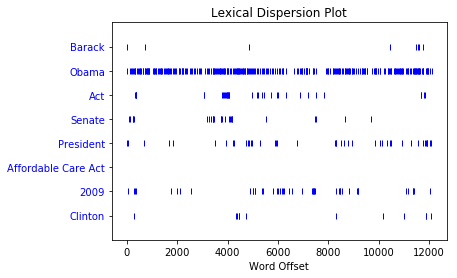

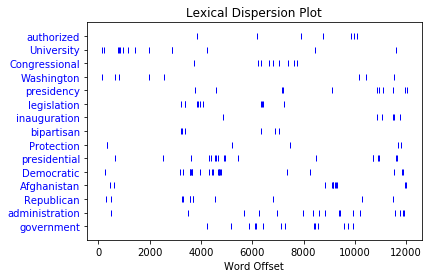

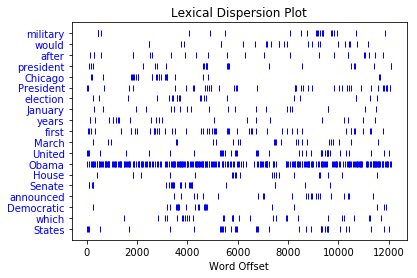

In [4]:
freq_dist = nltk.FreqDist(obama)
V = set(obama)

long_words = [w for w in V if len(w) > 3 and freq_dist[w] > 5]
super_long = [w for w in V if len(w) > 9 and freq_dist[w] > 5]
common_words = [w for w in V if len(w) > 4 and freq_dist[w] > 20]

obama.dispersion_plot(['Barack', 'Obama', 'Act', 'Senate', 'President', 'Affordable Care Act', '2009', 'Clinton'])
obama.dispersion_plot(super_long)
obama.dispersion_plot(common_words)

Assuming that we are using the Barack Obama data set, the interesting thing that comes from these word offset plots is clearly the chunking in groups in the data that happens. Clearly some blocks are more defined together than others. Obama obviously shows up the most, but there are some intersting things to glean, like Afhanistan shows up heavy in one block, but nowhere else. As does Presidential, and Chicago. 

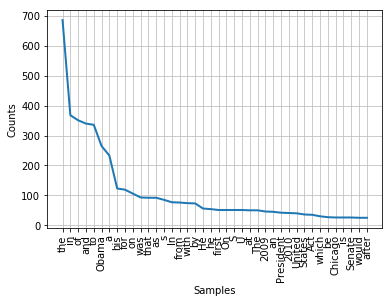

In [5]:
obama.plot(40)

This shows a plot of all the common words in the corpus, and their frequency; however, it's pretty disappointingly uninformative (at least in the Obama example) because of the simplicity of the words. Let's try removing unimportant stop words.

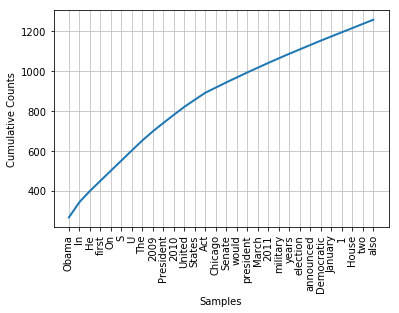

In [6]:
filtered_words = [word for word in obama if word not in stopwords.words('english')]
filter_dist = nltk.FreqDist(filtered_words)

filter_dist.plot(30, cumulative=True)

This is a more interesting look at the words. Having removed stop words, we see that the frequency of words gives us some intersting looks into the Obama Presidency, having focused on military action, we are not surprised to see that show up in the most used words. There are basic interesting words. 

As we can see, this did an impressive job in finding the key words of the article, and understanding what they are. As far as we can tell, this is a vital step in the text synthesis of entire Wikipedia articles. In combination with ranking algorithms, we believe that we will able to generate pretty decent summaraiztions of articles on the fly. Obviously, we haven't been able to generate Wikipedia articles yet, but we feel very good about the results achieved. This is a massive undertaking, and so far the results are very promising. 

## Apply Machine Learning Algorithms

### Model Selection
A majority of the methods that we covered in class dealt with classification problems which are often very interesting, but the problem that we are aiming to answer does not deal with classification. For this reason, it doesn't really make sense to use many of the classifier algorithms from class, since we are doing an unsupervised generative text problem. For instance, we aren't interested in using XGBoost, or any form of trees to generate text, or wikipedia articles. We could specifically go through all of the models that we have been through in class and explain why each individual method does not apply, but this seems unnecesary and tedious. 

Our approach here is to use an Long Short-Term Memory (LSTM) network, which is a type of recurrent neural network that stores information about past states in order to predict the next state. In our case, each state is represented by individual letters. Recurrent nerual networks can be thought of similar to a markov chain, in that they examine the relation between the upcoming and past states. This model in particular implements clever methods of weighting the more recent events higher than those further in the past. These methods are the reasoning behind the naming of the model. 

### Implementation of LSTM
The next cells implements a class for an LSTM. The code was quite lengthy and we thought that including the code here did not provide any extra intuition for what we are doing, so we placed it in a seperate python script which you are welcome to comb through for deeper understanding. The architecture is something we learned last semester in a deep learning class, but by revisiting the code we were able to create a much more general approach that is applicable here. It will take in a dynamiclly sized text, and adjust the size and depth of the GRUs and the LSTM as needed to optimize the text generation based upon input size. The downside of this approach is obviously that the LSTM has no concept of content. It will generate strings of charachters, but not much else. 

Below we generate our text based on a corpus focusing on Steve Jobs.

reading text file


100%|██████████| 100/100 [05:01<00:00,  2.89s/it]


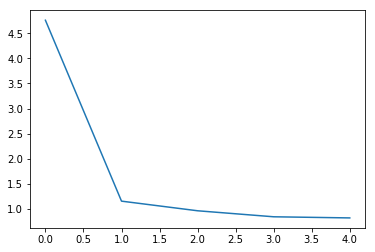

Barack Obama faver from Haway had the closures, and immigration politics after troops withe on years in his cession's adviceptal laucary after the incrustric Islass towards of the kity, Envertance cancese Prised deploy thromelted in policienton an February 2006 after the sime. Seneth publizing his second international Affairs, he currere throughous to publishinating towe of his annual thet companetgerant. Wheld works, where his early. He supportersholl Tom Populy modte.. His awarded on him a femblot as the 


<LSTM.TextLSTM instance at 0x1208722d8>

In [7]:
TextLSTM(article_title, sample_size=500, iters=100)

Obviously, this is pretty bad, but the motivation behind using this as a summarization technique was that the main ideas presented in a corpus would show themselves as you sample from a trained net set on pulling out interesting word and letter combinations. Maybe our net is rudimentary, but more than likely we need to just approach the problem differently using algorithms we havne't covered. 

We do see the plot of the losses decreasing as we continue through the iterations. This is good, it's what we want to see minimized. 

So, the results are not that impressive. This is about what we expected from the algorithms that we have covered in class. We know of a variety of other algorithms that will aid in solving our problem that we intend to implement for the next stage of the project. 

## Apply new Machine Learning Method

### Methodology 1  - LexRank (Lexical PageRank)

An overview of information ranking methods are as follows:

1. Identify text units that best define the task at hand, and add them as vertices in the graph.
2. Identify relations that connect such text units, and use these relations to draw edges between vertices in the graph. Edges can be directed or undirected, weighted or unweighted.
3. Iterate the graph-based ranking algorithm until convergence.
4. Sort vertices based on their final score. Use the values attached to each vertex for ranking/selection decisions.

(Mihalcea)

In LexRank a graph whose nodes are sentences from the original document is created. These sentences are ranked based on their 'centrality'. In basic algorithms this is done using their position in the text, the frequency of the words that are contained, and other key phrases indicating importance. In this implementation sentences are ranked based on their similarity to a 'centroid' sentence. This is similar to the eigenface based facial recognition program we wrote last year. 

LexRank uses different weighting systems similar to those in a social network. Similar to other ranking algorithms LexRank doesn't only track the number of edges that are attached to a particular node in the network but also account for the importance of the nodes those edges are connected to. This gives each node a sense of 'prestige'. This eliminates sentences and information that may relate to each other, but are relatively unimportant to the document. This method is similar to PageRank, but differs in that the similarity graph is undirected. \

Below is our implementation of this method.

LexRank by Erkan: http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume22/erkan04a-html/erkan04a.html

In [8]:
def lexical_rank():    
    # Run the information sorting algorithm on the scraped text
    tokenizer = tokenizers.Tokenizer('english')    
    parse = plaintext.PlaintextParser(article_text, tokenizer)
    doc = parse.document  
    rank = lex_rank.LexRankSummarizer()

    #Print the top ten results of the sorting
    print('\nThe ranked data is as follows:')
    print('\n------------------------------')

    i = 0
    for s in rank(doc, 10):
        i+=1
        print('{}: {}'.format(i, s))
        print('\n')

lexical_rank()


The ranked data is as follows:

------------------------------
1: Illinois State Senator U.S.


2: He is the first African American to have served as president, as well as the first born outside the contiguous United States.


3: In 2008, Obama was nominated for president, a year after his campaign began, and after a close primary campaign against Hillary Clinton.


4: He was born to a white mother and a black father.


5: In the November 2004 general election, Obama won with 70% of the vote.


6: Obama appointed two women to serve on the Supreme Court in the first two years of his Presidency.


7: Obama signed the bill into law on March 23, 2010.


8: On August 31, 2010, Obama announced that the United States combat mission in Iraq was over.


9: During the initial years of the Obama administration, the U.S. increased military cooperation with Israel, including increased military aid, re-establishment of the U.S.-Israeli Joint Political Military Group and the Defense Policy Advisory 

We were impressed by the results of this ranking algorithm. It works better for some articles than others, but on the Barack Obama article it does a very good job at finding the most important information in the wikipedia article. This is especially true of top five sentences selected which all seemed to be critical information.

### Methodology 2 - TextRank

LexRank was good but we think that we can do better than this. We specifically want to extract the imprortant and interesting ideas, rather than sentences that contain these ideas. The following will use textblob in order to devise a list of the most interesting keywords. For information on how the TextRank algorithm works, please see https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf and https://github.com/ceteri/pytextrank. 

In essence, TextRank goes through, and creates probability distributions on chunks of words. It learns what is important by exploring important combinations of words, and what the mean with the surrounding context. It's based around measuring words, and where they fall in the corpus, to determine their importance. 

It also extracts and returns the most important words in the corpus as 'keywords.' These are the keywords that we want to use to solidify up a smaller summary text corpus. The code is included as a module in textrank.py, but is long and ugly. This is the execution, and database development of the actual algorithm. 

In [9]:
data = {'id':1, 'text':article_text}
with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

This is where we call the various calls on TextRank, and get back the keywords. By default, this prints the 12 most important keywords. As we move forward, it will be important to print a variable amount based on the size of the data.

In [10]:
! ./run.sh data.json

# install datasketch, spacy, statistics, textblob, textblob_aptagger

+ '[' 1 -ne 1 ']'
+ ./stage1.py data.json

real	0m23.406s
user	0m16.634s
sys	0m4.087s
+ ./stage2.py o1.json

real	0m23.200s
user	0m19.185s
sys	0m2.846s
+ ./stage3.py o1.json o2.json

real	0m35.403s
user	0m30.837s
sys	0m3.448s
+ ./stage4.py o2.json o3.json

real	0m15.869s
user	0m11.602s
sys	0m2.883s
+ cat o4.md
**excerpts:** Illinois State Senator U.S. in economics. Obama's parents divorced in March 1964. Sav. Obama formally announced his candidacy in January 2003. In the November 2004 general election, Obama won with 70 % of the vote. Obama cosponsored the Secure America and Orderly Immigration Act. On June 7, 2008, Clinton ended her campaign and endorsed Obama. Obama won 52.9 % of the popular vote to McCain's 45.7 %. The inauguration of Barack Obama as the 44th President took place on January 20, 2009. Obama reduced the secrecy given to presidential records. Obama signed the bill into law on March 23, 2010. Obama is frequently referred to as an exceptional orator. The Obama Presidenti

You can see that this pulls out some interesting information. The advantage of the TextRank algorithm is it's ability to extract both keywords, as well as most import excerpt sentences. There are some odd keywords in this, and overall we feel that the excerpts were more impressive. Furthermore, the differentiation from the LexRank is noteworthy. Are overarching goal is to create some algorithm (probably a neural net of sorts) to generate new text that melds together. However, we were unable to curate a dataset to test that net against, and it never really took off.

## Conclusion

We think that the results from both of our implemented methods of information ranking were interesting and surprisingly accurate. Scoring accuracy on information ranking is difficult to automate. We were not able to find any concrete methods for doing this, so for now we will have to settle for our own interpretations. As far as we could see most of the identified sentences and keyword phrases were some of the more important ideas throughout the studied corpus. 

In summary we were pleased with our results but wish that we could have pushed our methods even further. After extensive searching we were not able to find any papers or working implementations of keyword guided text generation which is what we would want to be able to finish our abstraction summarization method. Perhaps in coming years breakthroughs will be made in this topic, or perhaps we might be able to blend known methods to create a new method! 

Other fun tools could be incorporated with what we have created such as voice recognition used to verbally identify a corpus, if we could get abstraction completed the users would even be able to identify how much they want to hear of a topic either in word count or time length, perhaps even image recognition identifying objects and providing a summary of that item, place or person! The possibilities are exciting and we hope to be able to push this project even further in the future.